## Advection Diffusion : Heat Transfer

In this notebook, we try to solve the advection-diffusion problem in section 8.3 in [this book](https://link.springer.com/book/10.1007/978-3-319-15431-2). The strong form of the pde is defined as 

\begin{gather*}
\begin{cases}
-\nabla \cdot \big(\kappa(\mathbf{x};\mathbf{\mu}) \nabla u\big)  + \mathbf{b}(\mathbf{x}; \mathbf{\mu}) \cdot \nabla u  = s(\mathbf{x}) \quad \mathbf{x} \in \Omega(\mu_1)\\ 
u = 0 \quad \mathbf{x} \in \Gamma_D \\
\kappa(\mathbf{x};\mathbf{\mu}) \nabla u = 0 \quad \mathbf{x} \in \Gamma_N
\end{cases}
\end{gather*}


with 4 subdomains characterizing different materials and geometry. The prescribed coefficients and fields are defined as

\begin{gather*}
\kappa(\mathbf{x};\mathbf{\mu}) = \chi_{\Omega_1 \cup \Omega_4}(\mathbf{x}) + 100\chi_{\Omega_2}(\mathbf{x}) + \mu_3 
\chi_{\Omega_3}(\mathbf{x})
\end{gather*}

\begin{gather*}
\mathbf{b}(\mathbf{x}; \mathbf{\mu}) = \big[0, \chi_{\Omega_1} 162\mu_2 / (1 + 3\mu_1)^3 (x_1-2/3) (1+\mu_1-x_1)\big]^T
\end{gather*}

\begin{gather*}
s(\mathbf{x}) = 10 \chi_{\Omega_2}(\mathbf{x})
\end{gather*}

The geometry of the one of the subdomains is controlled via a geometric parameter $\mu_1$. The full domain is denoted as $\Omega(\mu_1) = (0,1+\mu_1) \times (0,1)$ consisting of 

\begin{align*}
\Omega_1(\mu_1) = (2/3, 1+\mu_1)\times (0,1), &\qquad  \Omega_2 = (1/3, 2/3)\times(0,1/6) \\
\Omega_3 = (0,2/3) \times (0.5,0.7), &\qquad \Omega_4 = (0,2/3) \times(0,1) \not \,\,(\Omega_2 \cup \Omega_3)
\end{align*}

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gmsh
import ufl
from mpi4py import MPI
from dolfinx import mesh, fem
from dolfinx.fem import FunctionSpace
from petsc4py.PETSc import ScalarType

In [2]:
# physical range stated in the book for rbm
# mu1 = (-0.2,0.6)
# mu2 = (1,15)
# mu3 = (2, 30)

# characteristic parameter sets
# mu1 = -0.1
# mu2 = 12
# mu3 = 30

mu1 = 0.6
mu2 = 5
mu3 = 12

# mu1 = 0.3
# mu2 = 15
# mu3 = 5

rectangular_geometries = {
    '1' : (2/3, 0, 0, 1/3+mu1, 1),
    '2' : (1/3, 0, 0, 1/3, 1/6),
    '3' : (0, 0.5, 0, 2/3, 0.2),
    # top portion of \Omega_4
    '4a' : (0, 0.7, 0, 2/3, 0.3),
}

temporary_geometries = {
    # bottom portion of \Omega_4 chopped horizontally
    '4b-1' : (0, 1/6, 0, 2/3, 0.5 - 1/6),
    '4b-2' : (0, 0, 0, 1/3, 1/6)
}

boundary_locators = {
    'left' : lambda x : np.isclose(x[0], 0),
    'right' : lambda x : np.isclose(x[0], 1),
    'bottom' : lambda x : np.isclose(x[1], 0),
    'top' : lambda x : np.isclose(x[1], 1),
}

boundary_groups = {
    'left' : 1,
    'right' : 2,
    'bottom' : 3,
    'top' : 4,
}

In [3]:
model_name = 'advection-diffusion-heat-transfer'
model_name_short = 'adht'
gdim = 2
gmsh.initialize()
gmsh.model.add(model_name)

field_tag = gmsh.model.mesh.field.add('MathEval')
gmsh.model.mesh.field.setString(field_tag, 'F', '0.01')  # Adjust the value as needed
gmsh.model.mesh.field.setAsBackgroundMesh(field_tag)

boundary_groups = {
    'left' : 1, # dirichlet
    'right' : 2, # neumann
    'top' : 3, # neumann
    'bottom' : 4, # neumann
}

if MPI.COMM_WORLD.rank == 0:
    omega = {
        label : gmsh.model.occ.addRectangle(*domain) for label, domain in rectangular_geometries.items()
    }
    
    temp_omega = [gmsh.model.occ.addRectangle(*domain) for label, domain in temporary_geometries.items()]
    fused = gmsh.model.occ.fuse([(gdim, temp_omega[0])], [(gdim, tag) for tag in temp_omega[1:]])
    omega['4b'] = fused[0][0][1]
    
    gmsh.model.occ.synchronize()
    
    gmsh.model.occ.fragment([(gdim, tag) for _, tag in omega.items()], [])
    gmsh.model.occ.synchronize()

    # check position of the geometric objects
    center_of_mass = {
        tag : gmsh.model.occ.getCenterOfMass(dim, tag) for dim, tag in gmsh.model.getEntities(dim=2)
    }
    
    physical_groups = np.unique([int(k[0]) for k in omega.keys()])
    for group_id in physical_groups:
        subdomains = [v for k, v in omega.items() if int(k[0]) == group_id]
        gmsh.model.addPhysicalGroup(2, subdomains, group_id)
        
    boundary_tags = {}
    for label, locator in boundary_locators.items():
        boundary_tags[label] = [
            tag for dim, tag in gmsh.model.getEntities(dim=gdim-1) if locator(gmsh.model.occ.getCenterOfMass(dim, tag))
        ]
        gmsh.model.addPhysicalGroup(1, boundary_tags[label], boundary_groups[label])

    gmsh.option.setNumber('Mesh.Algorithm', 7)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize('Netgen')
    
    gmsh.write(f'{model_name_short}.msh')
    
gmsh.finalize()

Info    : Cannot bind existing OpenCASCADE surface 5 to second tag 6
Info    : Could not preserve tag of 2D object 6 (->5)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 80%] Meshing curve 14 (Line)
Info    : [ 90%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 16 (TrimmedCurve)
Info    : [100%] Meshing curve 17 (Line)
Info    : Done meshing 1D (Wall 0.0129776s, CPU 0.016203s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Bamg)
Info    : [  0%] BAMG suc

To verify the mesh generation, plot the expected subdomains (shades) and the calculated 'center of mass' (black star).

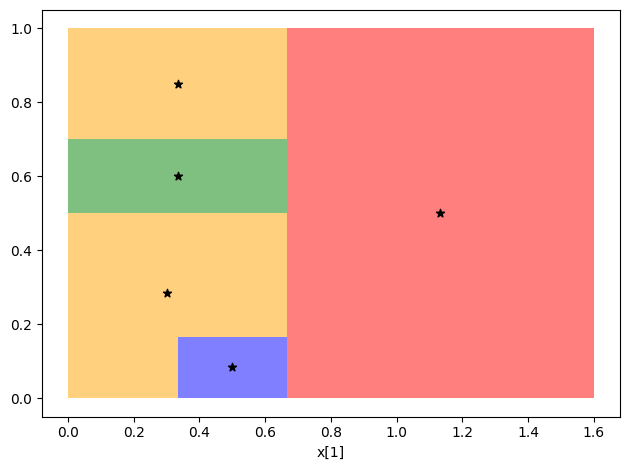

In [4]:
fig, ax = plt.subplots()
colors = ['r', 'b', 'g', 'orange']
for label, geometry in rectangular_geometries.items():
    color = colors[int(label[0]) - 1]
    ax.add_patch(mpl.patches.Rectangle(geometry[:2], *geometry[-2:], facecolor=color, edgecolor='none', alpha=0.5))
    
for label, geometry in temporary_geometries.items():
    color = colors[int(label[0]) - 1]
    ax.add_patch(mpl.patches.Rectangle(geometry[:2], *geometry[-2:], facecolor=color, edgecolor='none', alpha=0.5))
    
for tag, com in center_of_mass.items():
    ax.scatter(com[0], com[1], color='k', marker='*')

ax.set_xlabel('x[0]')
ax.set_xlabel('x[1]')

plt.tight_layout()
plt.show()


In [5]:
from dolfinx.io import gmshio
mesh, cell_markers, facet_markers = gmshio.read_from_msh(f'{model_name_short}.msh', MPI.COMM_WORLD, gdim=2)

Info    : Reading 'adht.msh'...
Info    : 35 entities
Info    : 20911 nodes
Info    : 41720 elements
Info    : Done reading 'adht.msh'


In [6]:
import meshio
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data('gmsh:physical', cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={'name_to_read':[cell_data]})
    return out_mesh

In [7]:
if MPI.COMM_WORLD.rank == 0:
    # Read in mesh
    msh = meshio.read(f'{model_name_short}.msh')
    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = create_mesh(msh, 'triangle', prune_z=True)
    line_mesh = create_mesh(msh, 'line', prune_z=True)
    meshio.write(f'mesh-{model_name_short}.xdmf', triangle_mesh)
    meshio.write(f'mt-{model_name_short}.xdmf', line_mesh)

In [8]:
from dolfinx.io import XDMFFile
with XDMFFile(MPI.COMM_WORLD, f'mesh-{model_name_short}.xdmf', 'r') as xdmf:
    mesh = xdmf.read_mesh(name='Grid')
    ct = xdmf.read_meshtags(mesh, name='Grid')
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim-1)
with XDMFFile(MPI.COMM_WORLD, f'mt-{model_name_short}.xdmf', 'r') as xdmf:
    ft = xdmf.read_meshtags(mesh, name='Grid')

In [9]:
Q = FunctionSpace(mesh, ('DG', 0))
kappa = fem.Function(Q)
chi = fem.Function(Q)

kappa_values = {
    1 : 1,
    2 : 100,
    3 : mu3, 
    4 : 1
}

domain_cells = {k : ct.find(k) for k in kappa_values.keys()}
for k, v in kappa_values.items():
    cells = domain_cells[k]
    kappa.x.array[cells] = np.full_like(cells, v, dtype=ScalarType)
    chi_value = 1 if k == 1 else 0
    chi.x.array[cells] = np.full_like(cells, chi_value, dtype=ScalarType)


In [10]:
V = FunctionSpace(mesh, ('CG', 1))
u_bc = fem.Function(V)
left_facets = ft.find(boundary_groups['left'])
left_dofs = fem.locate_dofs_topological(V, mesh.topology.dim-1, left_facets)
bcs = [fem.dirichletbc(ScalarType(0), left_dofs, V)]

In [11]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
x = ufl.SpatialCoordinate(mesh)
b = ufl.as_vector([0, 162 * mu2 / (1 + mu1) ** 3 * (x[0] - 2/3) * (1 + mu1 - x[0])])
a = kappa * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx + chi * ufl.inner(b, ufl.grad(u)) * v * ufl.dx
L = fem.Constant(mesh, ScalarType(10)) * v * ufl.dx
problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={'ksp_type': 'preonly', 'pc_type': 'lu'})
uh = problem.solve()

In [12]:
import pyvista
pyvista.start_xvfb()
from dolfinx.plot import create_vtk_mesh

topology, cell_types, x = create_vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid.cell_data['Marker'] = ct.values[ct.indices<num_local_cells]
grid.set_active_scalars('Marker')

p = pyvista.Plotter(window_size=[800, 800])
p.add_mesh(grid, show_edges=True)
p.view_xy()
if not pyvista.OFF_SCREEN:
    p.show()

In [15]:
grid_uh = pyvista.UnstructuredGrid(*create_vtk_mesh(V))
grid_uh.point_data['u'] = uh.x.array.real
grid_uh.set_active_scalars('u')
p2 = pyvista.Plotter(window_size=[800, 800])
p2.add_mesh(grid_uh, show_edges=True)
p2.view_xy()
if not pyvista.OFF_SCREEN:
    p2.show()